In [78]:
# import library
import tensorflow as tf
import numpy as np

# seed value
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

# loading mnist
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("tmp/mnist")

# input shape
X = tf.placeholder(shape = [None, 28, 28, 1], dtype = tf.float32, name = 'X')

# capsule net dimensions
caps_1_maps = 32
caps1_n_caps = caps_1_maps * 6 * 6
caps_1_dims = 8

# convolution parameters
conv1_params = {
    "filters" : 256,
    "kernel_size"  : 9,
    "strides" : 1,
    "padding" : "valid",
    "activation" : tf.nn.relu
}

conv2_params = {
    "filters" : caps_1_maps * caps_1_dims,
    "kernel_size" : 9,
    "strides" : 2,
    "padding" : "valid",
    "activation" : tf.nn.relu
}

Extracting tmp/mnist/train-images-idx3-ubyte.gz
Extracting tmp/mnist/train-labels-idx1-ubyte.gz
Extracting tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting tmp/mnist/t10k-labels-idx1-ubyte.gz


## Architecture

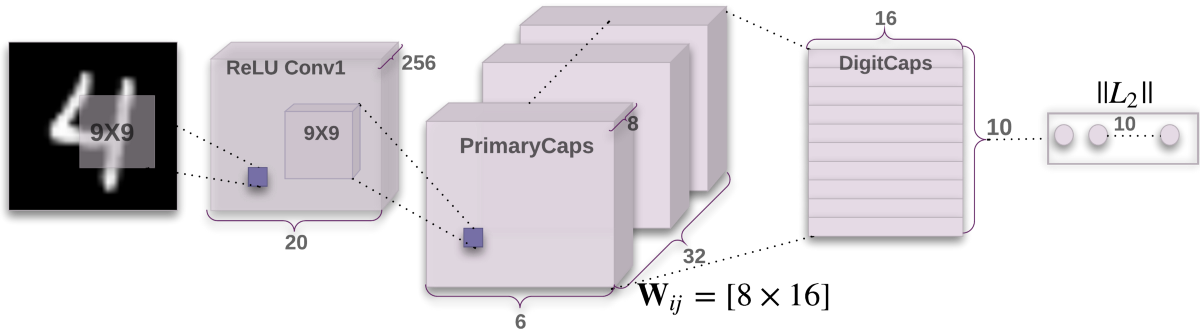

In [2]:
from IPython.display import display, Image
display(Image(filename='/home/karan/tensorflow/1_aJhYGZZPYF44UZMfFpKkfw.png'))

## Reconstruction Phase

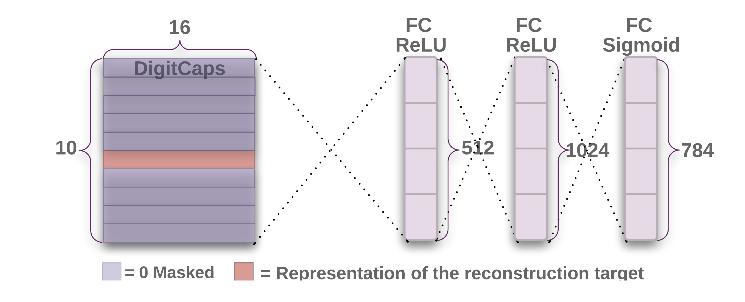

In [3]:
from IPython.display import display, Image
display(Image(filename='/home/karan/tensorflow/Screenshot from 2019-04-03 05-43-14.png'))

# Primary Capsule

### Squash Function

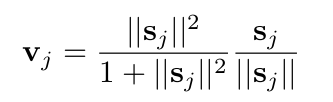

In [4]:
from IPython.display import display, Image
display(Image(filename='/home/karan/tensorflow/Screenshot from 2019-04-03 04-26-09.png'))

In [5]:
# Points :
# conventional CNN outputs scalar value(probabilites), capsule net outputs vector values.
# these vector values contain the information about probabilities, orientation, skew, thickness of the image for particular feature.
# input - (20*20*256)
# output - (6*6*32*8)

In [80]:
conv1 = tf.layers.conv2d(X, name = "conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name = "conv2", **conv2_params)

print(conv1.shape) # stride of 1 produces 20x20x256
print(conv2.shape) # stride of 2 produces 12x12/2 ==> 6x6x256

# reshaping it to produce (32 * 6 * 6, 8) = (1152, 8) (1152 - capsules of 8D vectors each)
# here we get the capsules via reshaping the scalar values to vector values.
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps_1_dims], name = "caps1_raw")
print(caps1_raw.shape)

# squash the vector values to 0-1
# need - to create a non-linearity same like 'relu'
# length of long vector goes to 1 and small vector goes to 0
def squash(s, axis = -1, epsilon = 1e-7, name = None): # -1 - along row side
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis = axis, keepdims = True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector


caps1_output = squash(caps1_raw, name = "caps1_output")
print(caps1_output.shape)

(?, 20, 20, 256)
(?, 6, 6, 256)
(?, 1152, 8)
(?, 1152, 8)


# Digit Capsule

# Digit caps converts 8D to 16D for each 10 digits. So, the output is 16*10

In [81]:
# points :
# input - (6*6*32*8)
# output - (16*10)

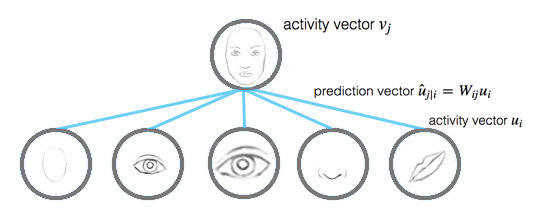

In [6]:
from IPython.display import display, Image
display(Image(filename='/home/karan/tensorflow/face6.jpg'))

In [82]:
# points :
# ui - is from primary capsule (remember - 1152 capsules)
# Wij - weigth matrix which will get updated during backpropagation with respect to loss.
# Wij - shape is 16 * 8
# uji = ui * wij
# vj is original vector(original image)
# uji and vj values are nearly same(with little up and down is okay) this means that particular feature is very same as in the original image.
# steps to calculate the similarity between uji and vj are explained in routing by agreement section.

In [83]:
caps2_n_caps = 10
caps2_n_dims = 16

init_sigma = 0.01

# creating weight matrix shape of 16*8 for all 10 digits
W_init = tf.random_normal(shape = (1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps_1_dims), stddev=init_sigma, dtype=np.float32, name = "W_init")
W = tf.Variable(W_init, name = "W")

print(W.shape)

batch_size = tf.shape(X)[0]

# removing the '1' and including the 'batch_size' and tiling it
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name = "W_tiled")
print(W_tiled.shape)

# expanding dims for primary capsule output because it is a vector, need to change it to array for MMultiplcation
caps1_output_expanded = tf.expand_dims(caps1_output, -1, name = "caps1_output_expanded")
print(caps1_output_expanded.shape)

# expanding dims to make it space for '10' in axis-2
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2, name = "caps1_output_tile")
print(caps1_output_tile.shape)

# including 10 and tiling it
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1], name = "caps1_output_tiled")
print(caps1_output_tiled.shape)

# matrix muliplication (Wij * ui)
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled, name = "caps2_predicted")
print(caps2_predicted.shape)

(1, 1152, 10, 16, 8)
(?, 1152, 10, 16, 8)
(?, 1152, 8, 1)
(?, 1152, 1, 8, 1)
(?, 1152, 10, 8, 1)
(?, 1152, 10, 16, 1)


# Routing By Agreement

In [84]:
# points :
# Rounting by agreement means sending only the essential capsule to next layer.
# In conventional CNN, we use max pooling to send only the essential one to next layer, same like here, we send only the important capsule to next layer.

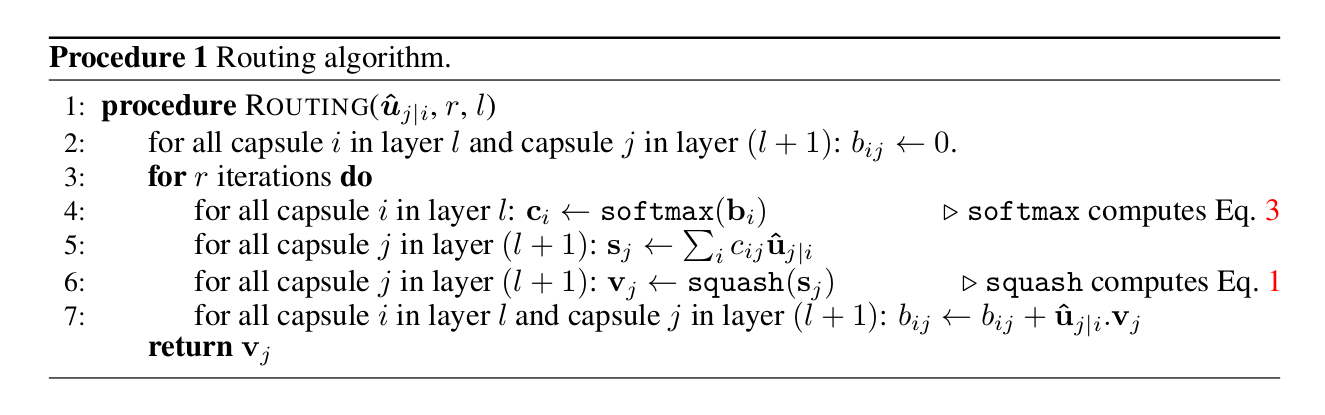

In [7]:
from IPython.display import display, Image
display(Image(filename='/home/karan/tensorflow/routing.png'))

### Iteration - 1

In [85]:
# intialize the 'bij' to zero
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1], dtype = np.float32, name = "raw_weights")
print(raw_weights.shape)

routing_weights = tf.nn.softmax(raw_weights, axis = 2, name = "routing_weights")
print(routing_weights.shape)

# caps2_predicted is the output of uji
weighted_predictions = tf.multiply(routing_weights, caps2_predicted, name = "weighted_predictions")
print(weighted_predictions.shape)

weighted_sum = tf.reduce_sum(weighted_predictions, axis = 1, keepdims = True, name = "weighted_sum")
print(weighted_sum.shape)

caps2_output_round_1 = squash(weighted_sum, axis = -2, name = "caps2_output_round_1")
print(caps2_output_round_1.shape)

caps2_output_round_1_tiled = tf.tile(caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1], name = "caps2_output_round_1_tiled")
print(caps2_output_round_1_tiled.shape)

agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled, transpose_a=True, name = "agreement")
print(agreement.shape)

(?, 1152, 10, 1, 1)
(?, 1152, 10, 1, 1)
(?, 1152, 10, 16, 1)
(?, 1, 10, 16, 1)
(?, 1, 10, 16, 1)
(?, 1152, 10, 16, 1)
(?, 1152, 10, 1, 1)


### Iteration - 2

In [86]:
raw_weights_round_2 = tf.add(raw_weights, agreement, name = "raw_weights_round_2")
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2, dim = 2, name = "routing_weights_round_2")

weighted_predictions_round_2 = tf.multiply(routing_weights_round_2, caps2_predicted, name = "weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2, axis = 1, keep_dims = True, name = "weighted_sum_round_2")

caps2_output_round_2 = squash(weighted_sum_round_2, axis = -2, name = "caps2_output_round_2")
caps2_output = caps2_output_round_2
print(caps2_output.shape)

(?, 1, 10, 16, 1)


## Predicting Probabilities

In [87]:
def safe_norm(s, axis = -1, epsilon = 1e-7, keep_dims = False, name = None):
    with tf.name_scope(name, default_name = "safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis = axis, keep_dims = keep_dims)
        return tf.sqrt(squared_norm + epsilon)

y_proba = safe_norm(caps2_output, axis = -2, name = "y_proba")
print(y_proba.shape)
y_proba_argmax = tf.argmax(y_proba, axis = 2, name = "y_proba_argmax")
print(y_proba_argmax.shape)
y_pred = tf.squeeze(y_proba_argmax, axis = [1, 2], name = "y_pred")
print(y_pred.shape)

(?, 1, 10, 1)
(?, 1, 1)
(?,)


## Margin Loss

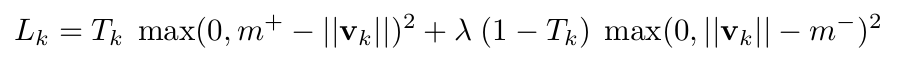

In [8]:
from IPython.display import display, Image
display(Image(filename='/home/karan/tensorflow/margin loss.png'))

In [88]:
# points :
# Tk = 1 if class is present else 0
# m_plus = 0.9
# m_minus = 0.1
# alpha = 0.5

In [89]:
# Margin loss
y = tf.placeholder(shape=[None], dtype = tf.int64, name = 'y')

m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

T = tf.one_hot(y, depth = caps2_n_caps, name = 'T')

caps2_output_norm = safe_norm(caps2_output, axis = -2, keep_dims = True, name = 'caps2_output_norm')

present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm), name = 'present_error_raw')
present_error = tf.reshape(present_error_raw, shape = (-1, 10), name = 'present_error')

absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus), name = 'absent_error_raw')
absent_error = tf.reshape(absent_error_raw, shape = (-1, 10), name = 'absent_error')

L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error, name = 'L')

margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis = 1), name = 'margin_loss')

# Reconstruction Phase

In [90]:
# steps :
# mask unwanted one
# reconstruct only the predicted one
# recontruction is from caps2output

In [91]:
# Reconstruction
mask_with_labels = tf.placeholder_with_default(False, shape = (), name = 'mask_with_labels')
print(mask_with_labels.shape)

reconstruction_targets = tf.cond(mask_with_labels, lambda : y, lambda : y_pred, name = 'reconstruction_targets')
print(reconstruction_targets.shape)

reconstruction_mask = tf.one_hot(reconstruction_targets, depth = caps2_n_caps, name = 'reconstruction_mask')
print(reconstruction_mask.shape)

reconstruction_mask_reshaped = tf.reshape(reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1], name = 'reconstruction_mask_reshaped')
print(reconstruction_mask_reshaped.shape)

caps2_output_masked = tf.multiply(caps2_output, reconstruction_mask_reshaped, name='caps2_output_masked')
print(reconstruction_mask_reshaped.shape)

decoder_input = tf.reshape(caps2_output_masked, shape = [-1, 160], name = 'decoder_input')
print(decoder_input.shape)

# Decoder
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input,n_hidden1, activation = tf.nn.relu, name = "hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu, name = 'hidden2')
    decoder_output = tf.layers.dense(hidden2, n_output, activation = tf.nn.softmax, name = "decoder_output")

# Reconstruction loss
X_flat = tf.reshape(X, [-1, n_output], name = 'X_flat')
squared_difference = tf.square(X_flat - decoder_output, name = 'squared_difference')
reconstruction_loss = tf.reduce_mean(squared_difference, name = 'reconstruction_loss')

()
(?,)
(?, 10)
(?, 1, 10, 1, 1)
(?, 1, 10, 1, 1)
(?, 160)


In [95]:
# Reconstruction loss
X_flat = tf.reshape(X, [-1, n_output], name = 'X_flat')
squared_difference = tf.square(X_flat - decoder_output, name = 'squared_difference')
reconstruction_loss = tf.reduce_mean(squared_difference, name = 'reconstruction_loss')

# Final loss
alpha = 0.0005
loss = tf.add(margin_loss, alpha * reconstruction_loss, name = "loss")

# Accuracy
correct = tf.equal(y, y_pred, name = "correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = "accuracy")

# Training operations
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name = "training_op")

# Init and Saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [96]:
# Training
n_epoch = 10
batch_size = 50
restore_checkpoint = True

n_iteration_per_epoch = mnist.train.num_examples // batch_size
n_iteration_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = './my_capsule_network'

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epoch):
        for iteration in range(1, n_iteration_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            _, loss_train = sess.run([training_op, loss], feed_dict={X: X_batch.reshape([-1, 28, 28, 1]), y: y_batch, mask_with_labels : True})
            print("Iteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(iteration, n_iteration_per_epoch, iteration * 100 / n_iteration_per_epoch, loss_train))

        loss_vals = []
        acc_vals = []

        for iteration in range(1, n_iteration_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_batch.reshape([-1, 28, 28, 1]), y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(iteration, n_iteration_validation, iteration * 100 / n_iteration_validation))

        loss_val = np.mean(loss_vals)
        acc_vals = np.mean(acc_val)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(epoch + 1, acc_val * 100, loss_val," (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Iteration: 1/1100 (0.1%)  Loss: 0.00440
Iteration: 2/1100 (0.2%)  Loss: 0.00131
Iteration: 3/1100 (0.3%)  Loss: 0.00292
Iteration: 4/1100 (0.4%)  Loss: 0.00066
Iteration: 5/1100 (0.5%)  Loss: 0.00041
Iteration: 6/1100 (0.5%)  Loss: 0.00108
Iteration: 7/1100 (0.6%)  Loss: 0.00544
Iteration: 8/1100 (0.7%)  Loss: 0.00136
Iteration: 9/1100 (0.8%)  Loss: 0.00099
Iteration: 10/1100 (0.9%)  Loss: 0.00092
Iteration: 11/1100 (1.0%)  Loss: 0.00165
Iteration: 12/1100 (1.1%)  Loss: 0.00675
Iteration: 13/1100 (1.2%)  Loss: 0.00277
Iteration: 14/1100 (1.3%)  Loss: 0.00502
Iteration: 15/1100 (1.4%)  Loss: 0.00084
Iteration: 16/1100 (1.5%)  Loss: 0.00137
Iteration: 17/1100 (1.5%)  Loss: 0.00046
Iteration: 18/1100 (1.6%)  Loss: 0.00297
Iteration: 19/1100 (1.7%)  Loss: 0.00082
Iteration: 20/1100 (1.8%)  Loss: 0.00343
Iteration: 21/1100 (1.9%)  Loss: 0.00488
Iteration: 22/1100 (2.0%)  Loss: 0.00349
Iteration: 23/1100 (2.1%)  Loss: 0.00250
Ite

KeyboardInterrupt: 